In [1]:
# Disable GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from bokeh.plotting import output_notebook
output_notebook()

Loading BokehJS ...

In [4]:
%cd ..

D:\anomaly-detection


In [5]:
from src.utils import *

In [6]:
data = pd.read_csv('data/processed/tep_data.csv', index_col='Index')
print(f'Len of dataset: {data.shape[0]}')

Len of dataset: 12801


In [7]:
from src.features.build_features import rolling_window

window_length = 64
prediction_len = 2
component = 3


X = rolling_window(data, window_length, 0)[:-prediction_len, :, component, None]
y = rolling_window(data, window_length, prediction_len)[:, :, component, None]

## Train model

In [8]:
# import src.models.lstm
# import importlib
# importlib.reload(src.models.lstm)

In [9]:
from src.models.lstm import build_model
import keras

build_params = dict(
    input_length=window_length,
    input_shape=1,
    lstm_layers_size=[2, 2],
    dropout_coeff=0.1,
    optimizer=keras.optimizers.Adam(lr=0.01),
    reg_strength=0.005,
)

fit_params = dict(
    batch_size=64,
    epochs=10,
    verbose=1,
    callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3),
               keras.callbacks.EarlyStopping(min_delta=0.01, patience=5)]
)

Using TensorFlow backend.


In [ ]:
from src.utils import cross_validate

results = cross_validate(lambda: build_model(**build_params), 3, fit_params, X, y)

In [ ]:
from src.visualization.visualize import visualize_result

visualize_result(results, f'Window length = {window_length}')

In [15]:
model = build_model(**build_params)
model.fit(X, y, **fit_params)

Epoch 1/10
12735/12735 [==============================] - 16s 1ms/step - loss: 0.4269
Epoch 2/10
  128/12735 [..............................] - ETA: 14s - loss: 0.3672

/home/elch10/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/elch10/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


12735/12735 [==============================] - 15s 1ms/step - loss: 0.3535
Epoch 3/10
12735/12735 [==============================] - 15s 1ms/step - loss: 0.3432
Epoch 4/10
12735/12735 [==============================] - 15s 1ms/step - loss: 0.3375
Epoch 5/10
12735/12735 [==============================] - 15s 1ms/step - loss: 0.3337
Epoch 6/10
12735/12735 [==============================] - 15s 1ms/step - loss: 0.3315
Epoch 7/10
12735/12735 [==============================] - 15s 1ms/step - loss: 0.3302
Epoch 8/10
12735/12735 [==============================] - 15s 1ms/step - loss: 0.3289
Epoch 9/10
12735/12735 [==============================] - 15s 1ms/step - loss: 0.3280
Epoch 10/10
12735/12735 [==============================] - 15s 1ms/step - loss: 0.3274


In [16]:
model.save('models/onedimensional_lstm.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64, 2)             32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 2)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64, 2)             40        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 64, 1)             3         
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________


## Generation and anomaly prediction

In [24]:
from src.data.generate import generate_anomalies
data_with_anom = data[str(component)].copy()
anom_amount = 100
anom_idxs_start = np.random.choice(len(data_with_anom),
                                   anom_amount,
                                   replace=False)
anom_lens = np.zeros(anom_amount, dtype=int)
anom_idxs = np.zeros(len(data_with_anom), dtype=int)

for i, idx in enumerate(anom_idxs_start):
    l = np.random.randint(window_length, window_length * 2)

    if idx + l > data_with_anom.shape[0]:
        raise Exception('Try again, index out of range (FIXME THEN)')

    anom_lens[i] = l
    anoms = generate_anomalies(l)
    anom_idxs[idx:idx + l] = 1
    data_with_anom[idx:idx + l] = anoms[np.random.randint(len(anoms))]

In [25]:
X_anom = rolling_window(pd.DataFrame(data_with_anom), window_length)[:-prediction_len]

In [10]:
from keras.models import load_model

model = load_model('models/onedimensional_lstm.h5')

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


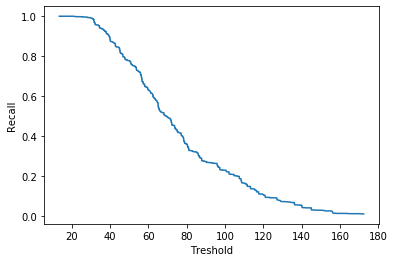

In [38]:
from src.utils import recall_all_tresh, compute_diff

treshs, recalls = recall_all_tresh(compute_diff(model, X_anom, y), anom_idxs[:len(diff)], window_length)
# norm_trehs, norm_recalls = recall_all_tresh(compute_diff(model, X, y), anom_idxs[:len(diff)], window_length)

plt.plot(treshs, recalls)
plt.xlabel('Treshold')
plt.ylabel('Recall');

Выберем какой-нибудь порог

In [41]:
idx = 2000
recall = recalls[idx]
tresh = treshs[idx]
anoms_pred = np.where(diff >= tresh)[0]
print(f'Recall={recall}, tresh={tresh:.2f} at index={idx}')

Recall=0.5160470289164284, tresh=67.99 at index=2000


In [42]:
from bokeh.plotting import figure, show
from src.utils import *

p = figure(plot_width=800,
           plot_height=600,
           tools="xwheel_zoom,pan,box_zoom,reset")

# all_data
# anomalies generated
# model predicted


p.multi_line(
    [
        data_with_anom.index,
        *[list(range(idx, idx + l)) for idx, l in zip(anom_idxs_start, anom_lens)],
        *[list(range(idx, idx + window_length)) for idx in anoms_pred],
    ],
    [
        data_with_anom,
        *[
            data_with_anom.iloc[idx:idx + l]
            for idx, l in zip(anom_idxs_start, anom_lens)
        ],
        *[data_with_anom.iloc[idx:idx + window_length] for idx in anoms_pred],
    ],
    color=["green", *['red'] * len(anom_idxs_start), *['blue'] * len(anoms_pred)],
    alpha=[0.4, *[0.6] * len(anom_idxs_start), *[0.6] * len(anoms_pred)],
    line_width=4,
    legend=f'Recall score: {recall:.2f}',
)

show(p)